In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

Returns a list of .jpg file paths from the given folder.

In [2]:
def get_image_paths(folder):
    image_paths = []
    for fname in os.listdir(folder):
        if fname.endswith('.jpg'):
            image_paths.append(os.path.join(folder, fname))
    return image_paths

Loads file paths of real and fake images using get_image_paths().

In [3]:
def load_image_paths(real_folder, fake_folder):
    return {
        'real': get_image_paths(real_folder),
        'fake': get_image_paths(fake_folder)
    }

Path to the dataset folder

In [4]:
dataset_real_folder = 'cifar_train_test/train/REAL'
dataset_fake_folder = 'cifar_train_test/train/FAKE'

image_paths = load_image_paths(dataset_real_folder, dataset_fake_folder)

Reads and displays an image using OpenCV and Matplotlib.

In [5]:
def show_image(image_path, title="Image"):
    img = cv2.imread(image_path)  # Read the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Show the image
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

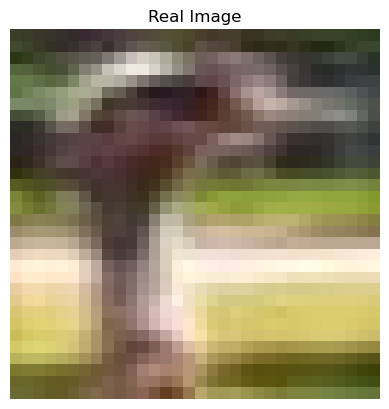

In [6]:
show_image(image_paths['real'][0], title="Real Image")

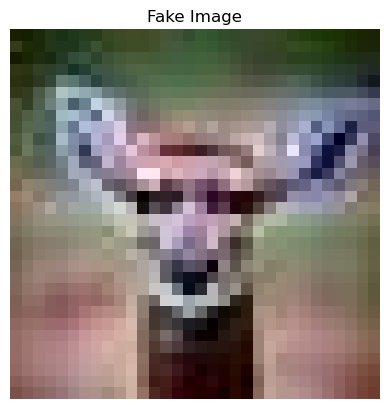

In [7]:
show_image(image_paths['fake'][0], title="Fake Image")

In [8]:
# Define dataset base directory
DATASET_PATH = "cifar_train_test"

# Train and test directories
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

In [13]:
# Create datasets
train_dataset = ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = ImageFolder(root=TEST_DIR, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

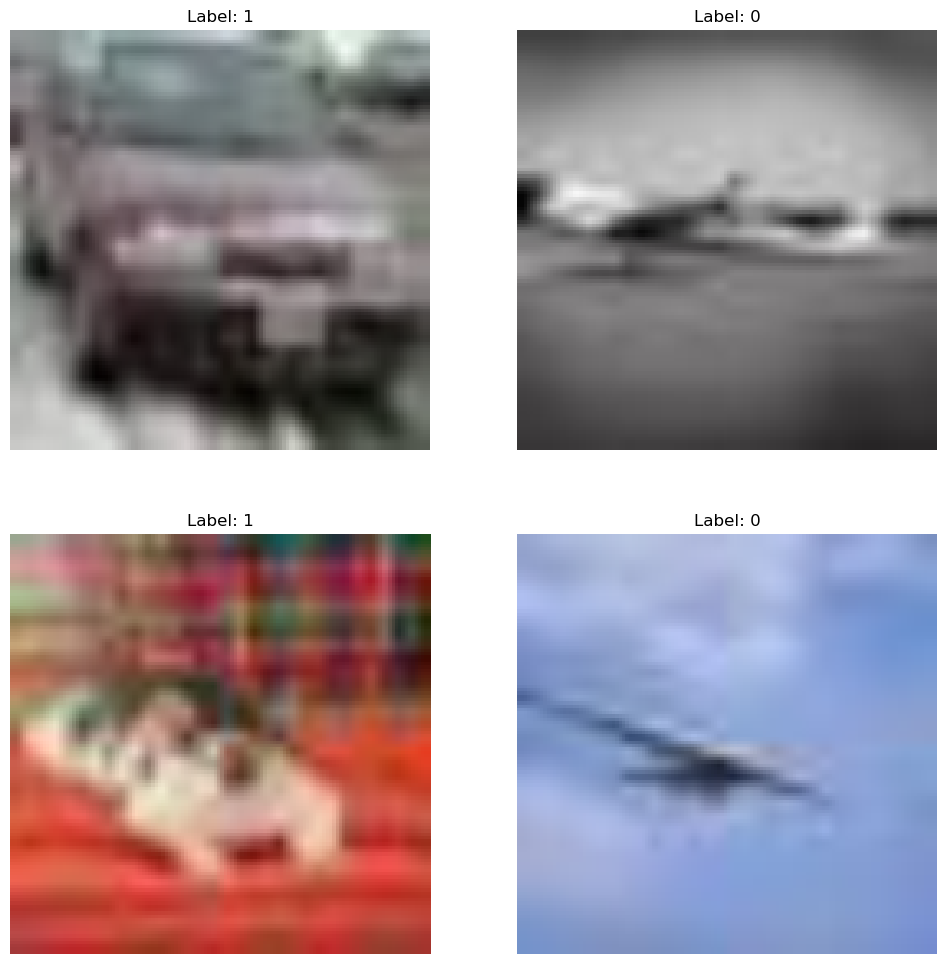

In [14]:
# Example: Show a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Displaying images
plt.figure(figsize=(12, 12))
for i in range(4):  # Show the first 4 images
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.show()

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

In [16]:
# Define the model (using a pre-trained ResNet18 model for example)
model = models.resnet18(pretrained=True)

# Modify the final layer to match your number of classes (for example, 2 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes: real and fake

/Users/ot/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ot/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ot/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.6MB/s]


In [17]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Training loop (for simplicity, assuming 1 epoch here)
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.19541060581415892
